# Exploratory analysis of mempool telementry experiment

## Set up

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(geosphere, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(ggraph, quietly=TRUE)
    require(igraph, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(maps, quietly=TRUE)
    require(RColorBrewer, quietly=TRUE)
    require(tidygraph, quietly=TRUE)
})

In [2]:
bauTime <- as.POSIXct("2025-11-22 02:00:00", tz = "UTC")

In [3]:
bauSlot <- 172210527

## Mempool vs blocks

In [4]:
mempoolBlocks <- fread("mempool-vs-blocks.tsv.gz", stringsAsFactors=TRUE)
colnames(mempoolBlocks) <- c("Region", "Slot", "Block hash", "Tx hash", "Tx hash8", "Slot time", "Block logged", "Tx logged", "Mempool - slot time [s]", "Block - slot time [s]", "Tx seen first", "Block utilization [%/100]")
mempoolBlocks[`Region` == '', `Region`:=NA]
mempoolBlocks %>% summary

            Region            Slot          
               :     0   Min.   :172020832  
 ap-northeast-1:141172   1st Qu.:172237207  
 eu-central-1  :191057   Median :172371668  
 us-east-2     :140292   Mean   :172358227  
 NA's          :  2423   3rd Qu.:172484179  
                         Max.   :172602993  
                                            
                                                            Block hash    
 4b9b817fb2ebd0959b7d31decc8225f6c4de874c2359706c327753c3961f4cc9:   237  
 b7dd177e8bf0ad0a52d41b1747bfde10b329ff4167bb408a5d7fef2735248e03:   234  
 90ab0197e16e39cf5af31bd1d193151f3582a2bee468ea953987e4b1c59de280:   224  
 b04ba46586aef364000ee0e42fa5fba6cdfae2294950e1ffb6c7fa2059fb7460:   222  
 9df8b4b6540b29d644074144490c0abb76d49ca62e11f9d4822ed1e0b6f8c0b2:   216  
 007e315be01f4cfb74e3c1c95f664aca16bf461be4cae4fe6e78e783896ea0b1:   201  
 (Other)                                                         :473610  
                                        

## Probability that a transaction is in one node's mempool, given that it is in another node's mempool.

In [5]:
arrivals <- dcast(
    mempoolBlocks[!is.na(`Tx logged`)],
    `Slot` + `Tx hash` + `Block utilization [%/100]` ~ `Region`,
    value.var = "Tx logged",
    fun.aggregate = function(x) {
        x[1]
    }
)
arrivals %>% summary

      Slot          
 Min.   :172024805  
 1st Qu.:172197809  
 Median :172352157  
 Mean   :172337772  
 3rd Qu.:172467828  
 Max.   :172602993  
                    
                                                             Tx hash      
 000076f241bac990ec1f45cda72f343f80bfe8d73fce67cc4328269d0fe13ae3:     1  
 000109649f9a8f10c9a4bd88bee05aa2b192b88c6f55c854157dc0a8860cafec:     1  
 00017d9d70055b1fa0a1827644fdc4b94bfb43c0606f62c017af4fe05d3f1664:     1  
 0001b087d39d2da5e69699d81bac4a6e580df07af5389952aefcfde632b9dc0e:     1  
 0001b9d5294bae38b731b1bcc1cdcf7c5119d31736b88d5bd9529668a0153eb8:     1  
 000216c68da0895ac434fec8b303eb0dd7e287806b73860f90d59ed48da6c89d:     1  
 (Other)                                                         :173256  
 Block utilization [%/100] ap-northeast-1                  
 Min.   :0.002131          Min.   :2025-11-21 18:13:20.31  
 1st Qu.:0.093883          1st Qu.:2025-11-23 04:35:53.61  
 Median :0.195762          Median :2025-11-24 12:29:

In [6]:
pxy <- function(x, y) {
    if (is.na(y))
        NA
    else if (is.na(x))
        0
    else
        1
}

In [7]:
combinations <-
    arrivals[, .(
        `Slot`,
        `Tx hash`,
        `Block utilization [%/100]`,
        `P(eu|ap)`=mapply(pxy, `eu-central-1`, `ap-northeast-1`),
        `P(us|ap)`=mapply(pxy, `us-east-2`, `ap-northeast-1`),
        `P(ap|eu)`=mapply(pxy, `ap-northeast-1`, `eu-central-1`),
        `P(us|eu)`=mapply(pxy, `us-east-2`, `eu-central-1`),
        `P(ap|us)`=mapply(pxy, `ap-northeast-1`, `us-east-2`),
        `P(eu|us)`=mapply(pxy, `eu-central-1`, `us-east-2`)
    )]
combinations %>% summary

      Slot          
 Min.   :172024805  
 1st Qu.:172197809  
 Median :172352157  
 Mean   :172337772  
 3rd Qu.:172467828  
 Max.   :172602993  
                    
                                                             Tx hash      
 000076f241bac990ec1f45cda72f343f80bfe8d73fce67cc4328269d0fe13ae3:     1  
 000109649f9a8f10c9a4bd88bee05aa2b192b88c6f55c854157dc0a8860cafec:     1  
 00017d9d70055b1fa0a1827644fdc4b94bfb43c0606f62c017af4fe05d3f1664:     1  
 0001b087d39d2da5e69699d81bac4a6e580df07af5389952aefcfde632b9dc0e:     1  
 0001b9d5294bae38b731b1bcc1cdcf7c5119d31736b88d5bd9529668a0153eb8:     1  
 000216c68da0895ac434fec8b303eb0dd7e287806b73860f90d59ed48da6c89d:     1  
 (Other)                                                         :173256  
 Block utilization [%/100]    P(eu|ap)        P(us|ap)        P(ap|eu)    
 Min.   :0.002131          Min.   :0.00    Min.   :0.00    Min.   :0.000  
 1st Qu.:0.093883          1st Qu.:1.00    1st Qu.:1.00    1st Qu.:0.000  
 Median

In [8]:
probabilities <- combinations[
    ,
    .(
        `P(eu|ap)`=mean(`P(eu|ap)`, na.rm=TRUE),
        `P(us|ap)`=mean(`P(us|ap)`, na.rm=TRUE),
        `P(ap|eu)`=mean(`P(ap|eu)`, na.rm=TRUE),
        `P(us|eu)`=mean(`P(us|eu)`, na.rm=TRUE),
        `P(ap|us)`=mean(`P(ap|us)`, na.rm=TRUE),
        `P(eu|us)`=mean(`P(eu|us)`, na.rm=TRUE)
    ),
    .(
        `BAU?`=`Slot`>=bauSlot
    )
]
probabilities

BAU?,P(eu|ap),P(us|ap),P(ap|eu),P(us|eu),P(ap|us),P(eu|us)
<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,0.9822689,0.2015837,0.1195024,0.02676552,0.8547445,0.9328467
TRUE,0.9372497,0.9154157,0.9791523,0.91508573,0.9695700,0.9277430


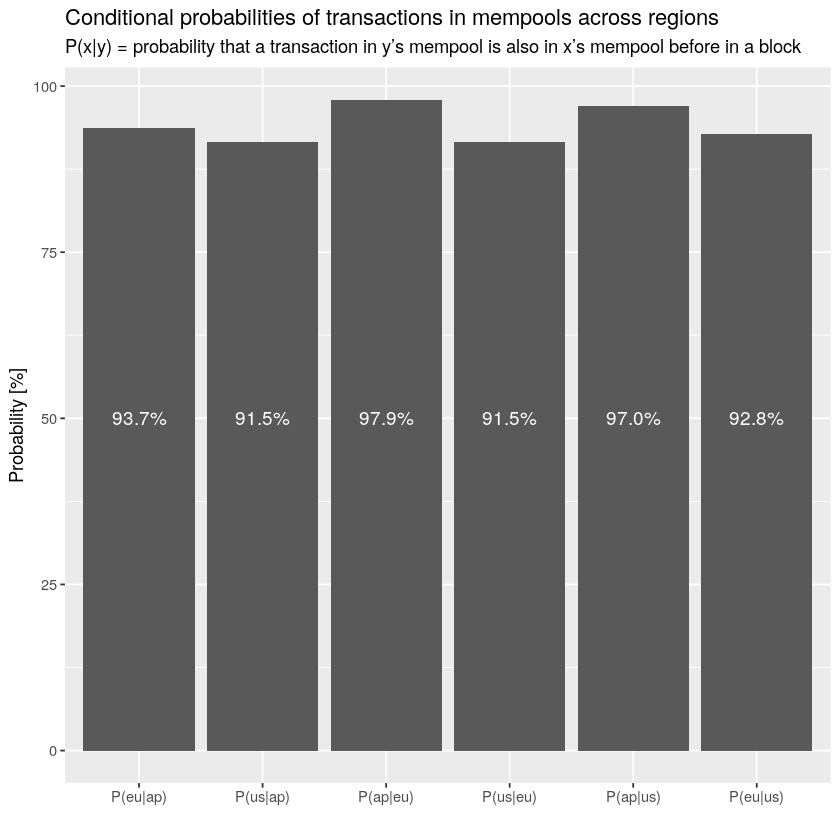

In [9]:
ggplot(
    melt(probabilities, id.vars="BAU?", variable.name="Condition", value.name="Probability")[`BAU?` == TRUE, .(`Condition`, `Probability [%]`=100*`Probability`)],
    aes(x=`Condition`, y=`Probability [%]`)
) +
    geom_bar(stat="identity") +
    geom_text(
        aes(label=sprintf("%.1f%%", `Probability [%]`)),
        y=50,
        size=4,
        color="white"
      ) +
    xlab("") +
    ggtitle(
        "Conditional probabilities of transactions in mempools across regions",
        "P(x|y) = probability that a transaction in y’s mempool is also in x’s mempool before in a block"
    )

In [10]:
ggsave("conditional-probability-regions.png", units="in", dpi=150, width=8, height=6)

In [11]:
ggsave("conditional-probability-regions.svg", units="in", dpi=150, width=8, height=6)

### As a function of block utilization

In [12]:
probabilities1 <-
    melt(combinations, id.vars=c("Slot", "Tx hash", "Block utilization [%/100]"), variable.name="Condition", value.name="Probability")[
        `Slot`>=bauSlot & !is.na(`Probability`),
        .(`Probability [%]`=100*mean(`Probability`)),
        .(`Slot`, `Block utilization [%]`=factor(2*round(50*`Block utilization [%/100]`,-1)), `Condition`)
    ]

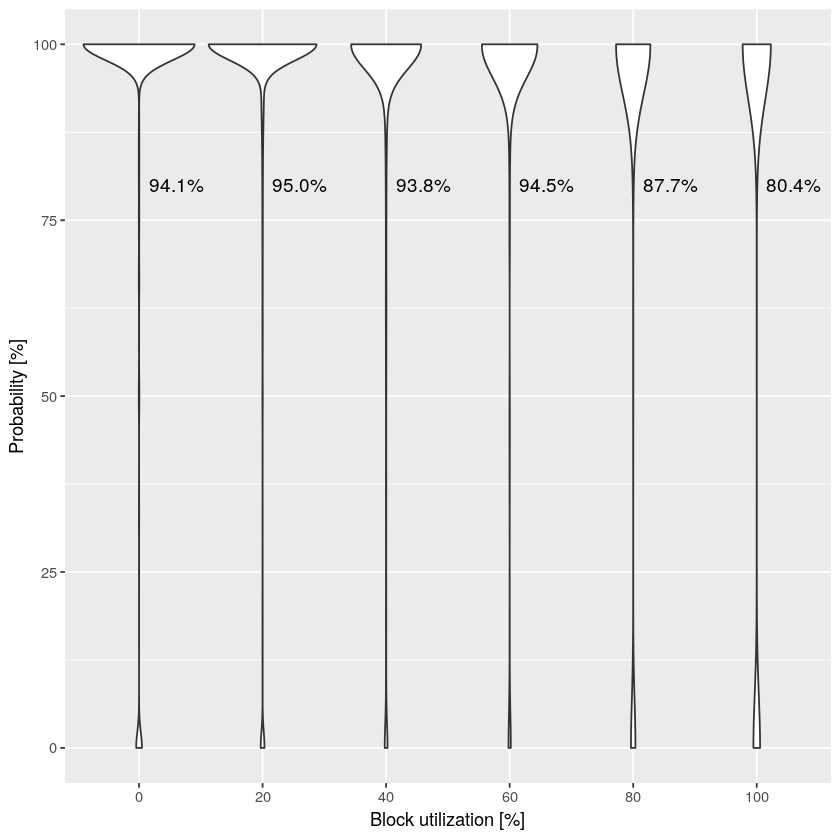

In [13]:
ggplot(
    probabilities1,
    aes(x=`Block utilization [%]`, y=`Probability [%]`)
) +
    geom_violin() +
    geom_text(
        data=probabilities1[, .(`Probability [%]`=mean(`Probability [%]`)), .(`Block utilization [%]`)],
        aes(label=sprintf("%.1f%%", `Probability [%]`)),
        nudge_x=0.3,
        y=80,
        size=4,
        color="black"
      )

In [14]:
ggsave("conditional-probability-utilization.png", units="in", dpi=150, width=8, height=6)

In [15]:
ggsave("conditional-probability-utilization.svg", units="in", dpi=150, width=8, height=6)

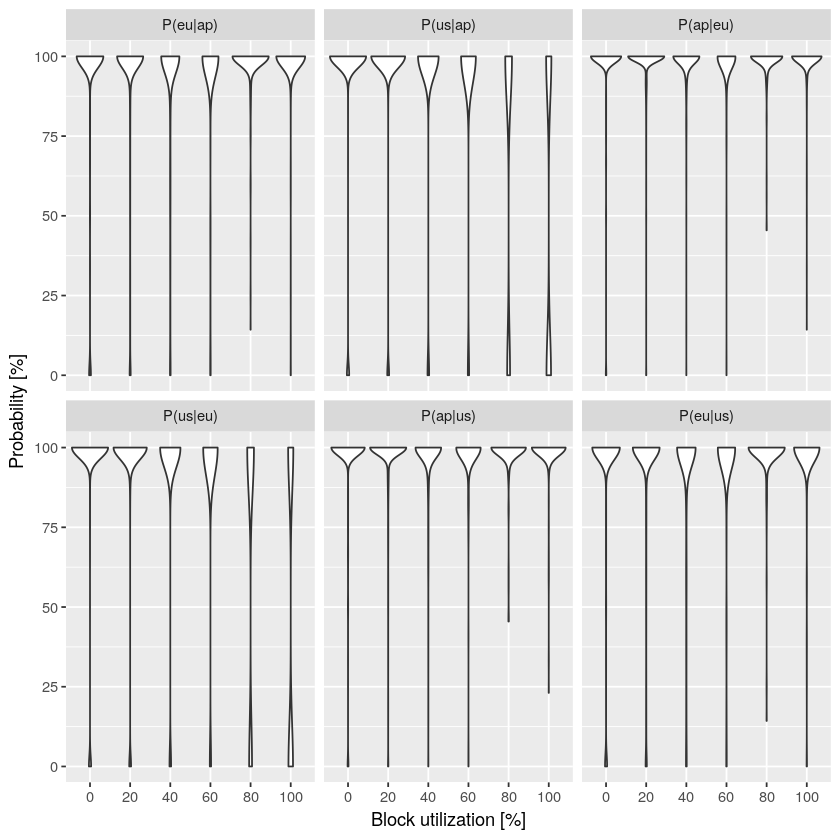

In [16]:
ggplot(
    melt(combinations, id.vars=c("Slot", "Tx hash", "Block utilization [%/100]"), variable.name="Condition", value.name="Probability")[
        `Slot`>=bauSlot & !is.na(`Probability`),
        .(`Probability [%]`=100*mean(`Probability`)),
        .(`Slot`, `Block utilization [%]`=factor(2*round(50*`Block utilization [%/100]`,-1)), `Condition`)
    ],
    aes(x=`Block utilization [%]`, y=`Probability [%]`)
) +
    geom_violin() +
    facet_wrap(`Condition` ~ .)

In [17]:
ggsave("conditional-probability-utilization-regions.png", units="in", dpi=150, width=8, height=6)

In [18]:
ggsave("conditional-probability-utilization-regions.svg", units="in", dpi=150, width=8, height=6)

## Probability that a transaction is in the node's mempool, given that it is later received in a block.

In [19]:
pmb <- mempoolBlocks[
    !is.na(`Region`),
    .(
        `P(mempool|block)`=mean(mapply(function(x) if (is.na(x)) 0 else 1, `Tx logged`))
    ),
    .(
        `Region`,
        `BAU?`=`Slot`>=bauSlot,
        `Block utilization > 85%`=`Block utilization [%/100]`>0.85
    )
]
pmb

Region,BAU?,Block utilization > 85%,P(mempool|block)
<fct>,<lgl>,<lgl>,<dbl>
ap-northeast-1,FALSE,FALSE,0.40893737
ap-northeast-1,FALSE,TRUE,0.00000000
ap-northeast-1,TRUE,FALSE,0.96587060
ap-northeast-1,TRUE,TRUE,0.98412514
eu-central-1,FALSE,FALSE,0.72085965
eu-central-1,FALSE,TRUE,0.86466524
eu-central-1,TRUE,FALSE,0.92275526
eu-central-1,TRUE,TRUE,0.97789096
us-east-2,FALSE,TRUE,0.06005057


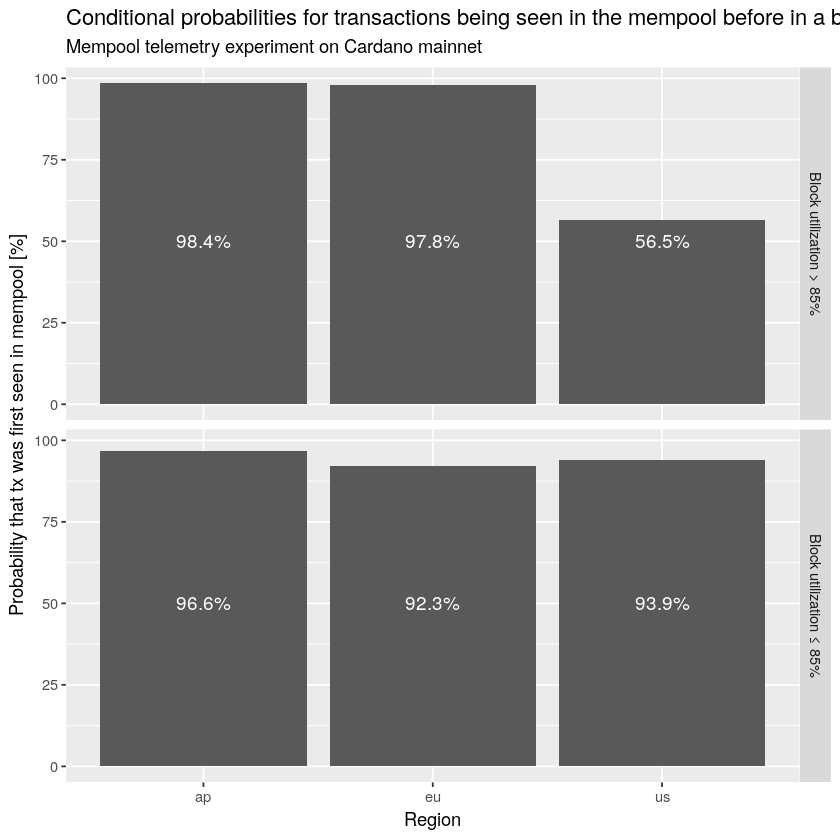

In [20]:
ggplot(
    pmb[
        `BAU?` == TRUE,
        .(
            `Region`=substr(`Region`,1,2), 
            `Probability that tx was first seen in mempool [%]`=100*`P(mempool|block)`,
            `Block utilization > 85%`=ifelse(`Block utilization > 85%`, "Block utilization > 85%", "Block utilization ≤ 85%")
        )
    ],
    aes(x=`Region`, y=`Probability that tx was first seen in mempool [%]`)
) +
    geom_bar(stat="identity") +
    geom_text(
        aes(label=sprintf("%.1f%%", `Probability that tx was first seen in mempool [%]`)),
        y=50,
        size=4,
        color="white"
    ) +
    facet_grid(`Block utilization > 85%` ~ .) +
    ggtitle(
        "Conditional probabilities for transactions being seen in the mempool before in a block",
        "Mempool telemetry experiment on Cardano mainnet"
    )

In [21]:
ggsave("conditional-probability-mempool-block.png", units="in", dpi=150, width=8, height=6)

In [22]:
ggsave("conditional-probability-mempool-block.svg", units="in", dpi=150, width=8, height=6)

## Distribution of a transaction's arrival time prior to the slot where the block was produced.

We see that the distribution of arrival times is consistent with uniformly distribution injection of transactions into the memory pool, rapid diffusion of them, and the block waiting time associated with the Praos active-slot coefficient.

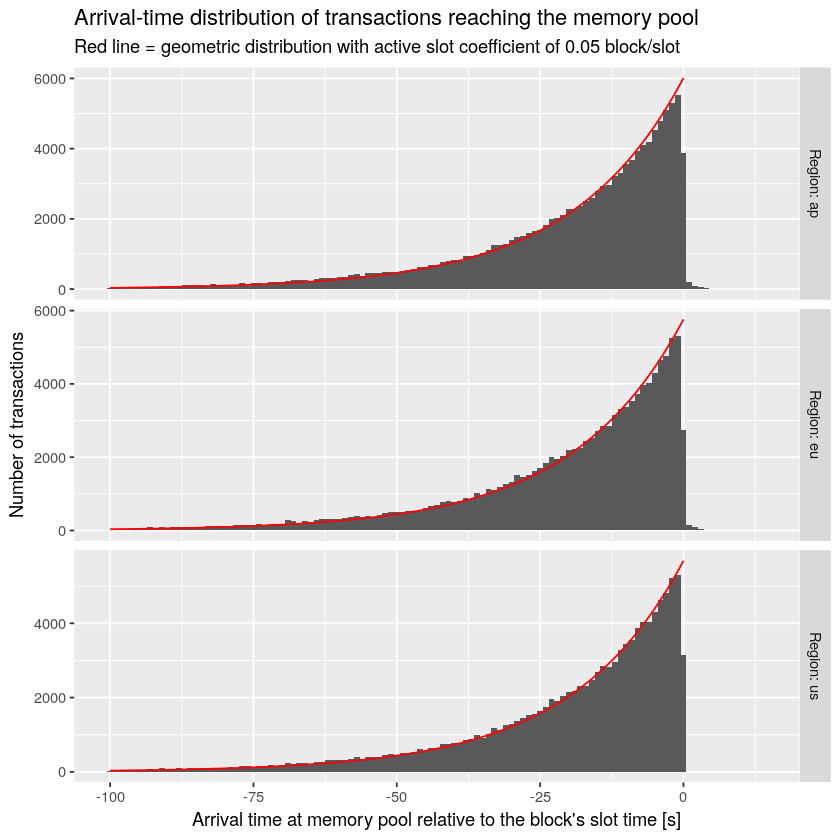

In [23]:
ggplot(
    mempoolBlocks[
        !is.na(`Region`) & `Slot` >= bauSlot  & `Tx seen first` == TRUE & `Mempool - slot time [s]` > -100, 
        .(`Region`=paste("Region:",substr(`Region`,1,2)), `Mempool - slot time [s]`)
    ], 
    aes(x=`Mempool - slot time [s]`)
) +
    geom_histogram(binwidth=1) +
    geom_line(
        data=CJ(`lag`=0:100, `Region`=paste("Region:",substr(mempoolBlocks[,unique(`Region`)],1,2)))[
            mempoolBlocks[
                !is.na(`Region`) & `Slot` >= bauSlot  & `Tx seen first` == TRUE & `Mempool - slot time [s]` > -100, 
                .N, 
                .(`Region`=paste("Region:",substr(`Region`,1,2)))
            ],
            on="Region"
        ][, .(`Region`, `lag`, `Count`=`N` * dgeom(`lag`, 0.05))],
        aes(x=-`lag`, y=`Count`),
        color="red"
    ) +
    facet_grid(`Region` ~ ., scales="free_y") +
    xlab("Arrival time at memory pool relative to the block's slot time [s]") +
    ylab("Number of transactions") +
    ggtitle(
        "Arrival-time distribution of transactions reaching the memory pool",
        "Red line = geometric distribution with active slot coefficient of 0.05 block/slot"
    )

In [24]:
ggsave("transaction-arrival.png", units="in", dpi=150, width=8, height=6)

In [25]:
ggsave("transaction-arrival.svg", units="in", dpi=150, width=8, height=6)

## Fraction of block's transactions received in the node's mempool before in their block.

In [26]:
pmbr <- mempoolBlocks[
    !is.na(`Region`),
    .(
        `P(mempool|block)`=mean(mapply(function(x) if (is.na(x)) 0 else 1, `Tx logged`))
    ),
    .(
        `BAU?`=`Slot`>=bauSlot,
        `Region`=paste("Region:",substr(`Region`,1,2)),
        `Slot`,
        `Block utilization > 85%`=factor(
            ifelse(`Block utilization [%/100]`>0.85, "Block utilization > 85%", "Block utilization ≤ 85%"),
            levels=c("Block utilization ≤ 85%", "Block utilization > 85%")
        )
    )
]
pmbr[, .(`P(mempool|block)`=mean(`P(mempool|block)`)), .(`BAU?`, `Region`, `Block utilization > 85%`)]

BAU?,Region,Block utilization > 85%,P(mempool|block)
<lgl>,<chr>,<fct>,<dbl>
FALSE,Region: ap,Block utilization ≤ 85%,0.48505184
FALSE,Region: ap,Block utilization > 85%,0.00000000
TRUE,Region: ap,Block utilization ≤ 85%,0.95989968
TRUE,Region: ap,Block utilization > 85%,0.98468790
FALSE,Region: eu,Block utilization ≤ 85%,0.64117577
FALSE,Region: eu,Block utilization > 85%,0.84879187
TRUE,Region: eu,Block utilization ≤ 85%,0.91710541
TRUE,Region: eu,Block utilization > 85%,0.97622911
FALSE,Region: us,Block utilization > 85%,0.06106573


A reasonable approximation for the fraction of a block's transactions being previously seen in the memory pool is a distribution with masses at 0% and 100% and a uniform distriubtion between those.

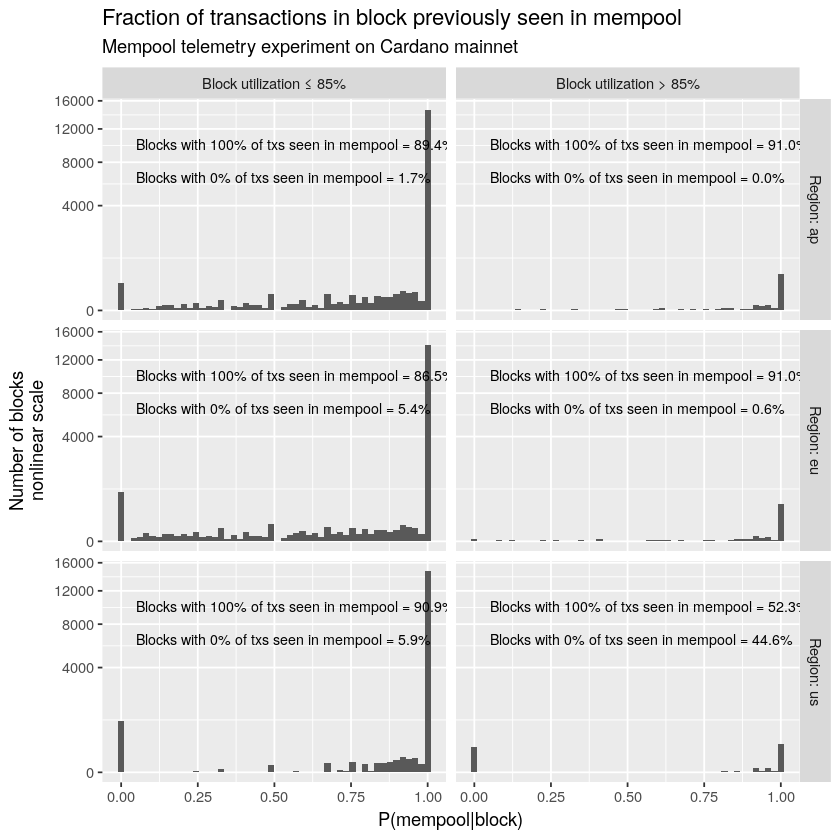

In [27]:
ggplot(pmbr[`BAU?` == TRUE], aes(x=`P(mempool|block)`)) +
    geom_histogram(bins=50) +
    geom_text(
        data=pmbr[
            `BAU?` == TRUE, 
            .(`Fraction = 0%`=mean(`P(mempool|block)`==0), `Fraction = 100%`=mean(`P(mempool|block)`==1)), 
            .(`Region`, `Block utilization > 85%`)
        ],
        aes(label=sprintf("Blocks with 0%% of txs seen in mempool = %.1f%%", 100 * `Fraction = 0%`)),
        x=0.05, y=80,
        hjust=0,
        size=3
    ) +
    geom_text(
        data=pmbr[
            `BAU?` == TRUE, 
            .(`Fraction = 0%`=mean(`P(mempool|block)`==0), `Fraction = 100%`=mean(`P(mempool|block)`==1)), 
            .(`Region`, `Block utilization > 85%`)
        ],
        aes(label=sprintf("Blocks with 100%% of txs seen in mempool = %.1f%%", 100 * `Fraction = 100%`)),
        x=0.05, y=100,
        hjust=0,
        size=3
    ) +
    scale_y_sqrt() +
    facet_grid(`Region` ~ `Block utilization > 85%`) +
    ylab("Number of blocks\nnonlinear scale") +
    ggtitle(
        "Fraction of transactions in block previously seen in mempool",
        "Mempool telemetry experiment on Cardano mainnet"
    )

In [28]:
ggsave("block-fraction.png", units="in", dpi=150, width=8, height=6)

In [29]:
ggsave("block-fraction.svg", units="in", dpi=150, width=8, height=6)

## Temporal autocorrelation of fraction of block's transactions received in the node's mempool before in their block.

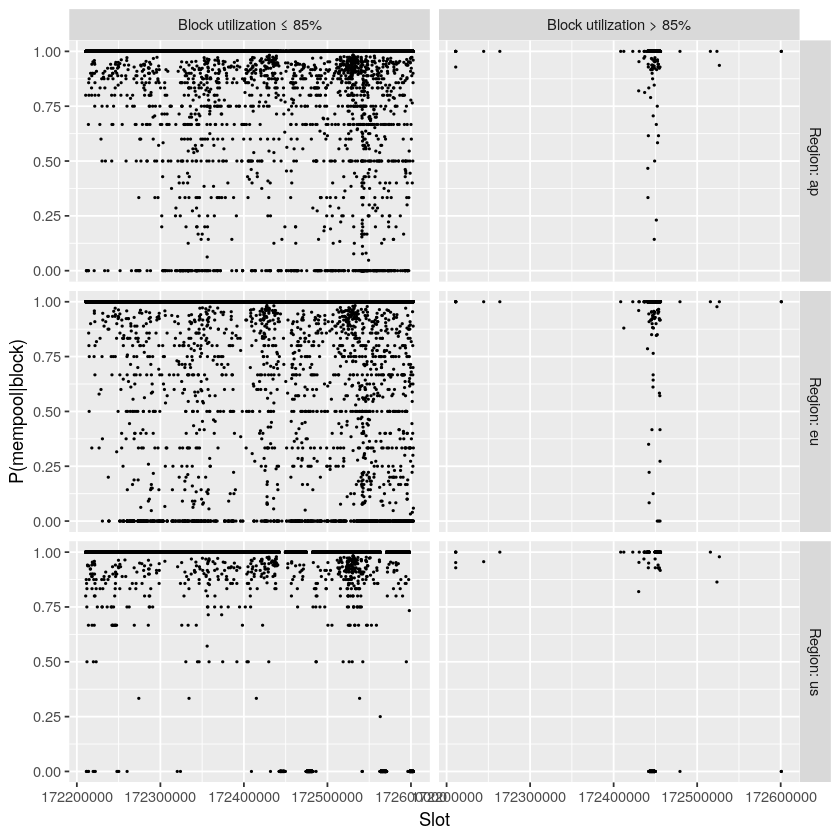

In [30]:
ggplot(pmbr[`BAU?` == TRUE], aes(x=`Slot`, y=`P(mempool|block)`)) +
    geom_point(size=0.25) +
    facet_grid(`Region` ~ `Block utilization > 85%`)

In [31]:
bacf <-
    rbind(
        cbind(
            `Region`="Region: ap",
            with(
                acf(pmbr[`BAU?` == TRUE & `Region`=="Region: ap", `P(mempool|block)`, .(`Slot`)][order(`Slot`)][, `P(mempool|block)`], lag.max=250, plot=FALSE),
                data.frame(lag, acf)
            )
        ),
        cbind(
            `Region`="Region: eu",
            with(
                acf(pmbr[`BAU?` == TRUE & `Region`=="Region: eu", `P(mempool|block)`, .(`Slot`)][order(`Slot`)][, `P(mempool|block)`], lag.max=250, plot=FALSE),
                data.frame(lag, acf)
            )
        ),
        cbind(
            `Region`="Region: us",
            with(
                acf(pmbr[`BAU?` == TRUE & `Region`=="Region: us", `P(mempool|block)`, .(`Slot`)][order(`Slot`)][, `P(mempool|block)`], lag.max=250, plot=FALSE),
                data.frame(lag, acf)
            )
        )
    )
colnames(bacf) <- c("Region", "Lag [blocks]", "Autocorrelation")
bacf %>% summary

    Region           Lag [blocks] Autocorrelation   
 Length:753         Min.   :  0   Min.   :0.006804  
 Class :character   1st Qu.: 62   1st Qu.:0.043884  
 Mode  :character   Median :125   Median :0.069114  
                    Mean   :125   Mean   :0.218570  
                    3rd Qu.:188   3rd Qu.:0.330734  
                    Max.   :250   Max.   :1.000000  

It is interesting the in the `ap` and `eu` region, the correlation for a block's transactions being previously seen in the mempool persists for less than five blocks but for the `us` region it persisted for hundreds of blocks.

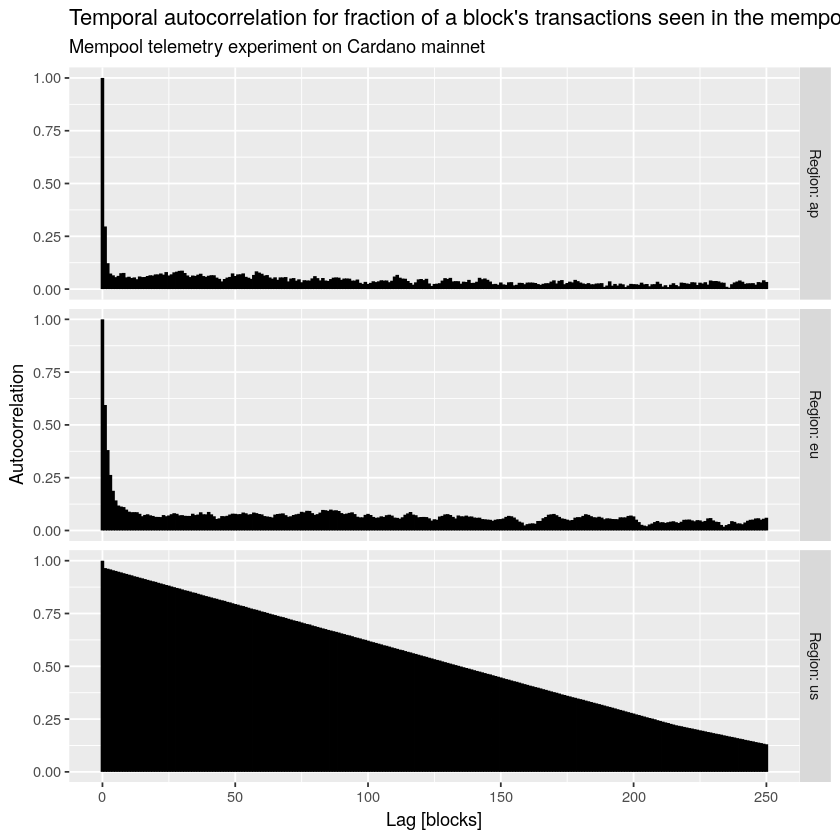

In [32]:
ggplot(bacf, aes(x=`Lag [blocks]`, y=`Autocorrelation`)) +
    geom_segment(aes(xend=`Lag [blocks]`, yend = 0), linewidth = 1) +
    facet_grid(`Region` ~ .) +
    ggtitle(
        "Temporal autocorrelation for fraction of a block's transactions seen in the mempool",
        "Mempool telemetry experiment on Cardano mainnet"
    )

In [33]:
ggsave("block-autocorrelation.png", units="in", dpi=150, width=8, height=6)

In [34]:
ggsave("block-autocorrelation.svg", units="in", dpi=150, width=8, height=6)

## Spatial autocorrelation of fraction of mempool transactions received in the node's mempool before in their block.

In [35]:
bcorLT <- cor(dcast(
    pmbr[`BAU?` == TRUE & `Block utilization > 85%` == "Block utilization ≤ 85%"], 
    `Slot` ~ `Region`, 
    value.var ="P(mempool|block)"
)[, -1], use="pairwise.complete.obs")
bcorLT

,Region: ap,Region: eu,Region: us
Region: ap,1.00000000,0.24720450,0.02290077
Region: eu,0.24720450,1.00000000,0.04533749
Region: us,0.02290077,0.04533749,1.00000000


In [36]:
bcorGT <- cor(dcast(
    pmbr[`BAU?` == TRUE & `Block utilization > 85%` == "Block utilization > 85%"], 
    `Slot` ~ `Region`, 
    value.var ="P(mempool|block)"
)[, -1], use="pairwise.complete.obs")
bcorGT

,Region: ap,Region: eu,Region: us
Region: ap,1.000000000,-0.003168562,-0.026439532
Region: eu,-0.003168562,1.000000000,0.001993177
Region: us,-0.026439532,0.001993177,1.000000000


At the block level there isn't much correlation between fractio of transactions seen in the mempool before in the block in different regions.

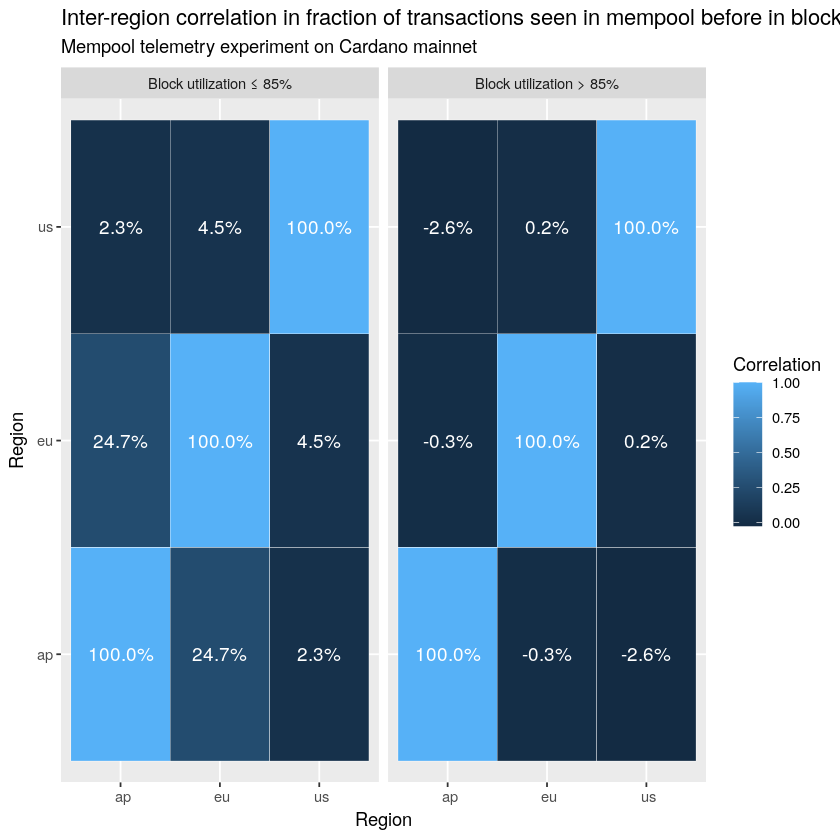

In [37]:
ggplot(
    rbind(
        cbind(
            `Block utilization > 85%`="Block utilization ≤ 85%",
            melt(cbind(`Region 1`=row.names(bcorLT), as.data.table(bcorLT)), id.vars="Region 1", variable.name="Region 2", value.name="Correlation")[, .(
                `Region 1`=substr(`Region 1`,8,10), `Region 2`=substr(`Region 2`,8,10), `Correlation`
            )]
        ),
        cbind(
            `Block utilization > 85%`="Block utilization > 85%",
            melt(cbind(`Region 1`=row.names(bcorGT), as.data.table(bcorGT)), id.vars="Region 1", variable.name="Region 2", value.name="Correlation")[, .(
                `Region 1`=substr(`Region 1`,8,10), `Region 2`=substr(`Region 2`,8,10), `Correlation`
            )]
        )
    ),
    aes(x=`Region 1`, y=`Region 2`, fill=`Correlation`)
) +
    geom_tile(color="white") +
    geom_text(aes(label=sprintf("%.1f%%",100*`Correlation`)), size = 4, color = "white") +
    facet_grid(. ~ factor(`Block utilization > 85%`, levels=c("Block utilization ≤ 85%", "Block utilization > 85%"))) +
    xlab("Region") +
    ylab("Region") +
    ggtitle(
        "Inter-region correlation in fraction of transactions seen in mempool before in block",
        "Mempool telemetry experiment on Cardano mainnet"
    )

In [38]:
ggsave("block-spatiocorrelation.png", units="in", dpi=150, width=8, height=6)

In [39]:
ggsave("block-spatiocorrelation.svg", units="in", dpi=150, width=8, height=6)

## Probability that a transaction is in a block received by a node, given that is was previously received in the node's memory pool.

Actually, there were no observations where a transaction reached a memory pool but didn't reach a block.

In [40]:
mempoolBlocks[is.na(`Block logged`) & !is.na(`Tx logged`), .N]

[1] 0

## Distribution of number of nodes that see that transactions before it appears in a block.

In [41]:
mempoolBlocks[
    `Slot` >= bauSlot, .N, .(`Region`, `Tx hash`)
][
    , .(`Number of regions`=.N), .(`Tx hash`)
][
    , .(`Number of transactions`=.N), .(`Number of regions`)
][
    order(`Number of regions`)
]

Number of regions,Number of transactions
<int>,<int>
1,69
2,196
3,125318


## Tracking of CF's "canary" transactions' arrival in memory pools.

In [42]:
canary <- fread("canary.tsv.gz", stringsAsFactors=TRUE)
colnames(canary) <- c("Canary address", "Tx hash", "Slot submitted", "Canary delay", "Block utilization [%/100]")
canary %>% summary

                                                    Canary address
 addr1vx2uvrm53dak4x3u0txy98r2jpg2nhy0n82vk8a6v9wmk4s8up888:163   
 addr1vx7gvyvy2r7mycya22f3x88wlgra2552uxm8xz2g0v3g6yccgyydv:163   
 addr1vxpvhtj5vvcqmf9td3vlvv4vza9nnuqrmkc42cnd42dg7fsz0v99d:163   
 addr1vy0zwnn5yj4h3s25xuere4h38np4z6gcng2mdgxg0mapxagl6x66d:162   
                                                                  
                                                                  
                                                                  
                                                             Tx hash   
 4efa94f4aa8b8aa5d59431752cf0c4d7306b4c321105c7ebfc015819b045c4fa:  2  
 53597b93ac2de670f6eeeeaaa658fd20c111ed8323cf26631c1fc44230ae2d45:  2  
 bbefe6d53028de74785758ee18a5b8fc0b2863c917a41bfe2785fd0fe73929ed:  2  
 f61a35f8f5ee8c0aac3bc84b7889a59b6c7bdde7ebdcb5c330353710da3cc1fb:  2  
 0003d419d3ed79b6d6711004e951e3e818d03a1df633b3e02070a6c84821f735:  1  
 00539f487af5aa4b01e48776987d1a7

In [43]:
canary[
    mempoolBlocks[!is.na(`Region`) & `Slot` >= bauSlot], 
    on="Tx hash", 
    nomatch=0
][!is.na(`Tx logged`), .N, .(`Canary address`, `Tx hash`, `Region`)][
    ,
    .(`Number of regions`=.N),
    .(`Canary address`, `Tx hash`)
][
    ,
    .(`Count`=.N),
    .(`Canary address`, `Number of regions`)
]

Canary address,Number of regions,Count
<fct>,<int>,<int>
addr1vy0zwnn5yj4h3s25xuere4h38np4z6gcng2mdgxg0mapxagl6x66d,3,92
addr1vxpvhtj5vvcqmf9td3vlvv4vza9nnuqrmkc42cnd42dg7fsz0v99d,3,91
addr1vx7gvyvy2r7mycya22f3x88wlgra2552uxm8xz2g0v3g6yccgyydv,3,92
addr1vx2uvrm53dak4x3u0txy98r2jpg2nhy0n82vk8a6v9wmk4s8up888,3,95
addr1vy0zwnn5yj4h3s25xuere4h38np4z6gcng2mdgxg0mapxagl6x66d,2,17
addr1vx2uvrm53dak4x3u0txy98r2jpg2nhy0n82vk8a6v9wmk4s8up888,2,14
addr1vxpvhtj5vvcqmf9td3vlvv4vza9nnuqrmkc42cnd42dg7fsz0v99d,2,17
addr1vx7gvyvy2r7mycya22f3x88wlgra2552uxm8xz2g0v3g6yccgyydv,2,16
addr1vxpvhtj5vvcqmf9td3vlvv4vza9nnuqrmkc42cnd42dg7fsz0v99d,1,1


In [44]:
canary[`Slot submitted` >= bauSlot, .N, .(`Canary address`)]

Canary address,N
<fct>,<int>
addr1vy0zwnn5yj4h3s25xuere4h38np4z6gcng2mdgxg0mapxagl6x66d,109
addr1vxpvhtj5vvcqmf9td3vlvv4vza9nnuqrmkc42cnd42dg7fsz0v99d,109
addr1vx7gvyvy2r7mycya22f3x88wlgra2552uxm8xz2g0v3g6yccgyydv,109
addr1vx2uvrm53dak4x3u0txy98r2jpg2nhy0n82vk8a6v9wmk4s8up888,109


Thus the majority of the transactions reached all three nodes.

## Tracking of natural and induced congestion on arrival in memory pools.

Each of these transactions was [8717 bytes](https://adastat.net/transactions/d798ed9489cdd977fa2155894edc27d3cb0137fcdb9454133448a242383e1384), so 20 of them completely fill a memory pool on a node configured with defaults.

In [45]:
20 * 8717

[1] 174340

In [46]:
congestions <- fread("congestions.tsv.gz", stringsAsFactors=TRUE)
colnames(congestions) <- c("Submission time", "Tx hash", "Block utilization [%/100]")
congestions %>% summary

 Submission time                 
 Min.   :2025-11-26 14:01:16.00  
 1st Qu.:2025-11-26 14:01:16.00  
 Median :2025-11-26 14:23:16.00  
 Mean   :2025-11-26 14:12:32.92  
 3rd Qu.:2025-11-26 14:23:16.00  
 Max.   :2025-11-26 14:23:16.00  
                                 
                                                             Tx hash  
 0ed21a6ff7e05561a73ebe454cbfc7bbea04c443529c23ec6440bb29724bcb4f: 1  
 0f55de2cd1cc3354297c855eb4ea62c4d6cf30e26fe9e010b9697bd553336e6c: 1  
 12be7f48a0bdd33a62df89c44b1ef6810d4d54ea26e7a4bf4c43e1fa3d8aa18f: 1  
 1f176c316231e138623364a4bed8574ceb070b2562c6867cf012e1c2cded6d7d: 1  
 2f93d4bade70efb1459923d14b1d5380565bd0313a9850b69c6b91c58451c205: 1  
 315c821bd42e69fd03425aab4564408bcdf9ce0de6e8f551259011a8aaac650a: 1  
 (Other)                                                         :33  
 Block utilization [%/100]
 Min.   :0.2944           
 1st Qu.:0.5373           
 Median :0.5373           
 Mean   :0.7269           
 3rd Qu.:0.9374          

In [47]:
congestions[
    mempoolBlocks[!is.na(`Region`) & `Slot` >= bauSlot], 
    on="Tx hash", 
    nomatch=0
][!is.na(`Tx logged`), .N, .(`Tx hash`, `Region`)][
    ,
    .(`Number of regions`=.N),
    .(`Tx hash`)
][
    ,
    .(`Count`=.N),
    .(`Number of regions`)
]

Number of regions,Count
<int>,<int>
1,19
2,20


In [48]:
congestions[, .N]

[1] 39

Thus only one or two of the nodes received a given transaction.

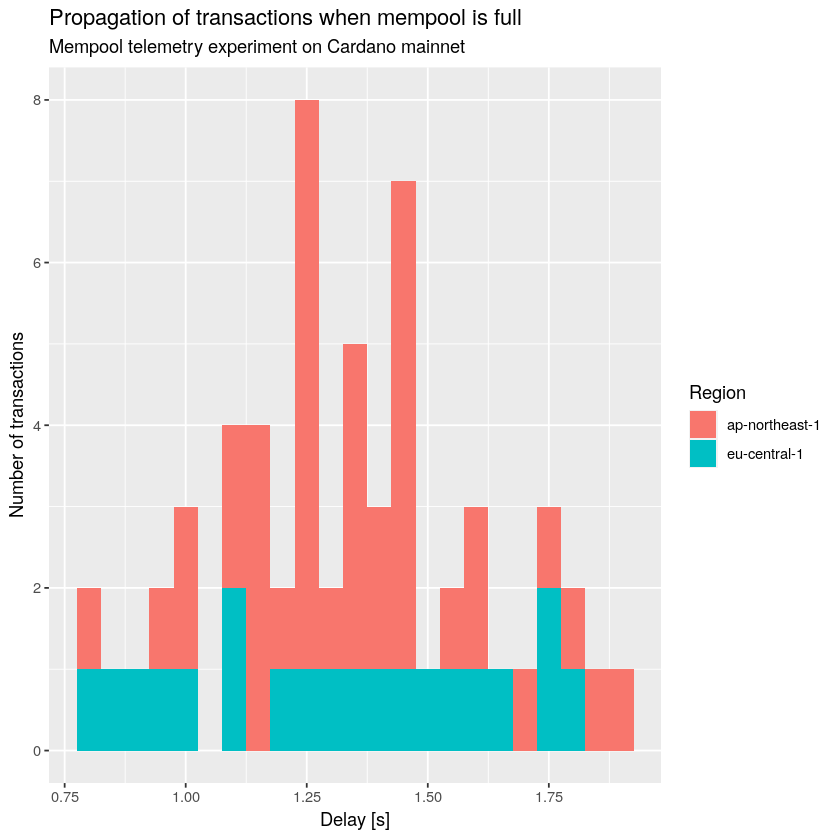

In [49]:
ggplot(
    congestions[
        mempoolBlocks[!is.na(`Region`) & `Slot` >= bauSlot], 
        on="Tx hash", 
        nomatch=0
    ][!is.na(`Tx logged`), .(`Delay [s]`=as.numeric(`Tx logged` - `Submission time`)), .(`Region`, `Tx hash`)],
    aes(x=`Delay [s]`, fill=`Region`)
) +
    geom_histogram(binwidth=0.05) +
    ylab("Number of transactions") +
    ggtitle(
        "Propagation of transactions when mempool is full",
        "Mempool telemetry experiment on Cardano mainnet"
    )

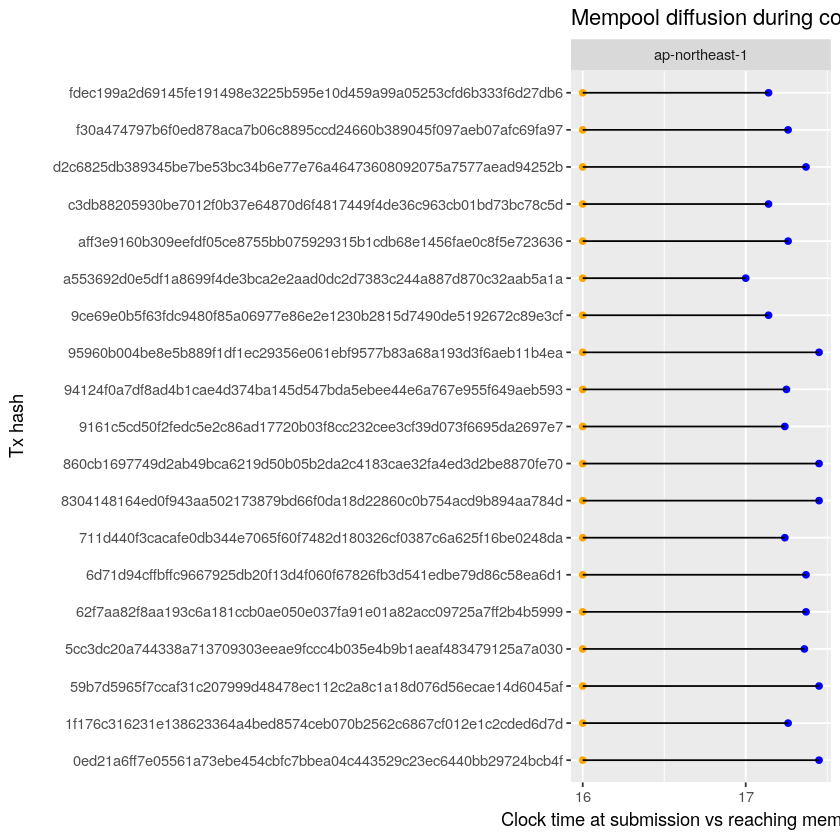

In [50]:
ggplot(
    congestions[
        mempoolBlocks[!is.na(`Region`) & `Slot` >= bauSlot], 
        on="Tx hash", 
        nomatch=0
    ][
        !is.na(`Tx logged`) & as.character(`Submission time`) < '2025-11-26 14:12:00', 
        .(`Region`, `Tx hash`, `Submission time`, `Tx logged`)
    ],
    aes(x=`Submission time`, y=`Tx hash`)
) +
    geom_point(color="orange") +
    geom_point(aes(x=`Tx logged`, y=`Tx hash`), color="blue") +
    geom_segment(aes(xend=`Tx logged`, yend=`Tx hash`), color="black") +
    facet_grid(. ~ `Region`, scales="free") +
    xlab("Clock time at submission vs reaching mempool [s]") +
    ggtitle("Mempool diffusion during congestion")

The previous plots shows that only one node ever received the transactions.

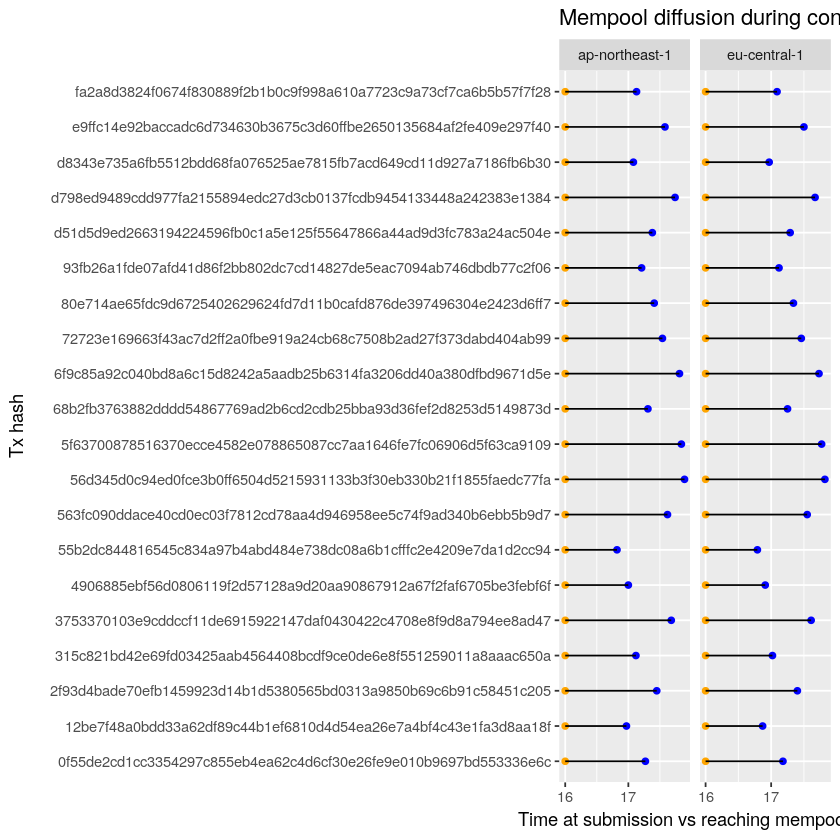

In [51]:
ggplot(
    congestions[
        mempoolBlocks[!is.na(`Region`) & `Slot` >= bauSlot], 
        on="Tx hash", 
        nomatch=0
    ][
        !is.na(`Tx logged`) & as.character(`Submission time`) > '2025-11-26 14:12:00', 
        .(`Region`, `Tx hash`, `Submission time`, `Tx logged`)
    ],
    aes(x=`Submission time`, y=`Tx hash`)
) +
    geom_point(color="orange") +
    geom_point(aes(x=`Tx logged`, y=`Tx hash`), color="blue") +
    geom_segment(aes(xend=`Tx logged`, yend=`Tx hash`), color="black") +
    facet_grid(. ~ `Region`, scales="free") +
    xlab("Time at submission vs reaching mempool [s]") +
    ggtitle("Mempool diffusion during congestion")

In [52]:
ggsave("congestion.png", units="in", dpi=150, width=8, height=6)

In [53]:
ggsave("congestion.svg", units="in", dpi=150, width=8, height=6)

The previous plot shows that only two nodes ever received the transactions.

## Mapping mempool connectivity

In [54]:
outbounds <- fread("outbounds.tsv.gz", stringsAsFactors=TRUE)
colnames(outbounds) <- c("Region", "Tx logged", "Local", "Remote", "Tx hash")
outbounds <- outbounds[, .(
    `Region`, 
    `Tx logged`, 
    `Local host`=sub(":.*$", "",`Local`)%>%as.factor, 
    `Local port`=sub(".*:", "", `Local`)%>%as.factor,
    `Remote host`=sub(":.*$", "",`Remote`%>%as.factor), 
    `Remote port`=sub(".*:", "", `Remote`%>%as.factor),
    `Tx hash`
)]
outbounds %>% summary

            Region          Tx logged                     
 ap-northeast-1: 368515   Min.   :2025-11-19 22:27:59.00  
 eu-central-1  :1445137   1st Qu.:2025-11-22 17:36:50.00  
 us-east-2     : 591678   Median :2025-11-24 00:51:10.00  
                          Mean   :2025-11-23 22:29:25.00  
                          3rd Qu.:2025-11-25 06:22:40.00  
                          Max.   :2025-11-26 15:01:21.00  
                                                          
          Local host      Local port     Remote host        Remote port       
 18.176.178.121: 368515   3001:2405330   Length:2405330     Length:2405330    
 18.218.69.112 : 591678                  Class :character   Class :character  
 52.28.55.26   :1445137                  Mode  :character   Mode  :character  
                                                                              
                                                                              
                                                      

In [55]:
connectivity <- outbounds[, .(`Tx count`=.N), .(`Region`, `Local host`, `Remote host`=as.factor(`Remote host`))]
connectivity %>% summary

            Region             Local host          Remote host  
 ap-northeast-1:327   18.176.178.121:327   104.131.122.73:   3  
 eu-central-1  :531   18.218.69.112 :311   109.228.150.84:   3  
 us-east-2     :311   52.28.55.26   :531   13.114.184.31 :   3  
                                           13.211.73.179 :   3  
                                           13.236.12.204 :   3  
                                           13.48.207.141 :   3  
                                           (Other)       :1151  
    Tx count    
 Min.   :    1  
 1st Qu.:  125  
 Median :  662  
 Mean   : 2058  
 3rd Qu.: 2082  
 Max.   :38075  
                

In [56]:
remoteGeo <- fread("reallyfreegeoip.tsv.gz", stringsAsFactors=TRUE)
remoteGeo %>% summary

             Remote    Longitude [deg]    Latitude [deg]  
 100.36.30.173  :  1   Min.   :-123.767   Min.   :-38.73  
 103.147.114.194:  1   1st Qu.: -73.968   1st Qu.: 37.75  
 103.73.64.137  :  1   Median :   8.567   Median : 48.20  
 104.131.122.73 :  1   Mean   :  -1.595   Mean   : 41.70  
 104.167.218.211:  1   3rd Qu.:  16.380   3rd Qu.: 50.48  
 104.225.220.71 :  1   Max.   : 174.768   Max.   : 69.63  
 (Other)        :818                                      

In [57]:
connectivityGeo <- connectivity[
    remoteGeo[, .(`Remote host`=as.factor(`Remote`), `Remote longitude [deg]`=`Longitude [deg]`, `Remote latitude [deg]`=`Latitude [deg]`)],
    on="Remote host",
    nomatch=0
][
    remoteGeo[, .(`Local host`=as.factor(`Remote`), `Local longitude [deg]`=`Longitude [deg]`, `Local latitude [deg]`=`Latitude [deg]`)],
    on="Local host",
    nomatch=0
]    
connectivityGeo %>% summary

            Region              Local host          Remote host  
 ap-northeast-1:327   52.28.55.26    :531   104.131.122.73:   3  
 eu-central-1  :531   18.176.178.121 :327   109.228.150.84:   3  
 us-east-2     :311   18.218.69.112  :311   13.114.184.31 :   3  
                      100.36.30.173  :  0   13.211.73.179 :   3  
                      103.147.114.194:  0   13.236.12.204 :   3  
                      103.73.64.137  :  0   13.48.207.141 :   3  
                      (Other)        :  0   (Other)       :1151  
    Tx count     Remote longitude [deg] Remote latitude [deg]
 Min.   :    1   Min.   :-123.767       Min.   :-38.73       
 1st Qu.:  125   1st Qu.: -74.010       1st Qu.: 37.75       
 Median :  662   Median :   6.861       Median : 48.20       
 Mean   : 2058   Mean   :  -1.714       Mean   : 41.70       
 3rd Qu.: 2082   3rd Qu.:  16.380       3rd Qu.: 50.48       
 Max.   :38075   Max.   : 174.768       Max.   : 69.63       
                                      

In [58]:
worldMap <- map_data("world")

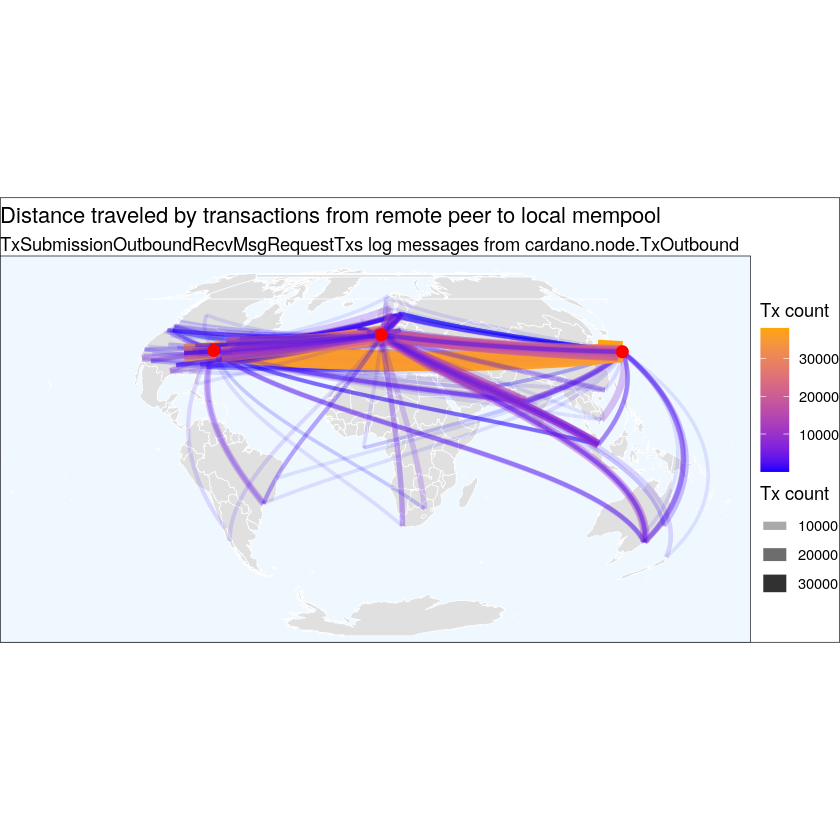

In [59]:
ggplot() +
    geom_polygon(
        data=worldMap, 
        aes(x=long, y=lat, group=group), 
        fill="#e0e0e0", color="white", linewidth=0.2
    ) +
    geom_segment(
        data=connectivityGeo, 
        aes(x=`Local longitude [deg]`, y=`Local latitude [deg]`, xend=`Remote longitude [deg]`, yend=`Remote latitude [deg]`, color=`Tx count`, linewidth=`Tx count`, alpha=`Tx count`)
    ) +
    geom_point(
        data=connectivityGeo[, .N, .(`Local longitude [deg]`, `Local latitude [deg]`)],
        aes(x=`Local longitude [deg]`, y=`Local latitude [deg]`),
        color="red", size=3
    ) +
    scale_color_gradient(low = "blue", high = "orange") +
  coord_map("aitoff") + 
  theme_void() +
  theme(plot.background = element_rect(fill = "white"), panel.background = element_rect(fill = "aliceblue")) +
    ggtitle(
        "Distance traveled by transactions from remote peer to local mempool",
        "TxSubmissionOutboundRecvMsgRequestTxs log messages from cardano.node.TxOutbound"
    )

In [60]:
ggsave("mempool-distance-map.png", units="in", dpi=150, width=8, height=6)

In [61]:
ggsave("mempool-distance-map.svg", units="in", dpi=150, width=8, height=6)

In [62]:
connectivityDistance <-
    connectivityGeo[, .(
        `Region`,
        `Local host`,
        `Remote host`,
        `Tx count`,
        `Distance [km]`=mapply(
            function(x1, y1, x2, y2) distHaversine(c(x1, y1), c(x2, y2))/1000, 
            `Local longitude [deg]`, 
            `Local latitude [deg]`,
            `Remote longitude [deg]`,
            `Remote latitude [deg]`
        )
    )]
connectivityDistance %>% summary

            Region              Local host          Remote host  
 ap-northeast-1:327   52.28.55.26    :531   104.131.122.73:   3  
 eu-central-1  :531   18.176.178.121 :327   109.228.150.84:   3  
 us-east-2     :311   18.218.69.112  :311   13.114.184.31 :   3  
                      100.36.30.173  :  0   13.211.73.179 :   3  
                      103.147.114.194:  0   13.236.12.204 :   3  
                      103.73.64.137  :  0   13.48.207.141 :   3  
                      (Other)        :  0   (Other)       :1151  
    Tx count     Distance [km]    
 Min.   :    1   Min.   :    0.0  
 1st Qu.:  125   1st Qu.:  768.4  
 Median :  662   Median : 6837.3  
 Mean   : 2058   Mean   : 5923.2  
 3rd Qu.: 2082   3rd Qu.: 9323.5  
 Max.   :38075   Max.   :18553.2  
                                  

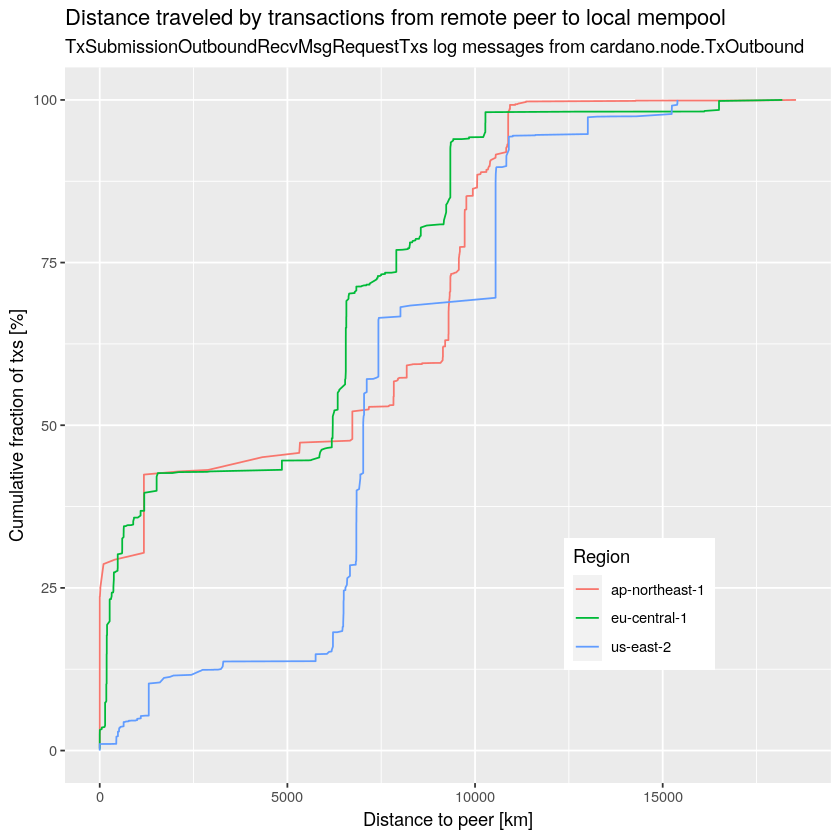

In [63]:
ggplot(
    connectivityDistance[order(`Region`, `Distance [km]`)][
        , 
        .(`Distance to peer [km]`=`Distance [km]`, `Cumulative fraction of txs [%]`=100*cumsum(`Tx count`)/sum(`Tx count`)), 
        .(`Region`)
    ],
    aes(x=`Distance to peer [km]`, y=`Cumulative fraction of txs [%]`, color=`Region`)
) +
    geom_line() +
    theme(legend.position = c(0.75, 0.25)
) +
    ggtitle(
        "Distance traveled by transactions from remote peer to local mempool",
        "TxSubmissionOutboundRecvMsgRequestTxs log messages from cardano.node.TxOutbound"
    )

In [64]:
ggsave("mempool-distance-cumulative.png", units="in", dpi=150, width=8, height=6)

In [65]:
ggsave("mempool-distance-cumalative.svg", units="in", dpi=150, width=8, height=6)

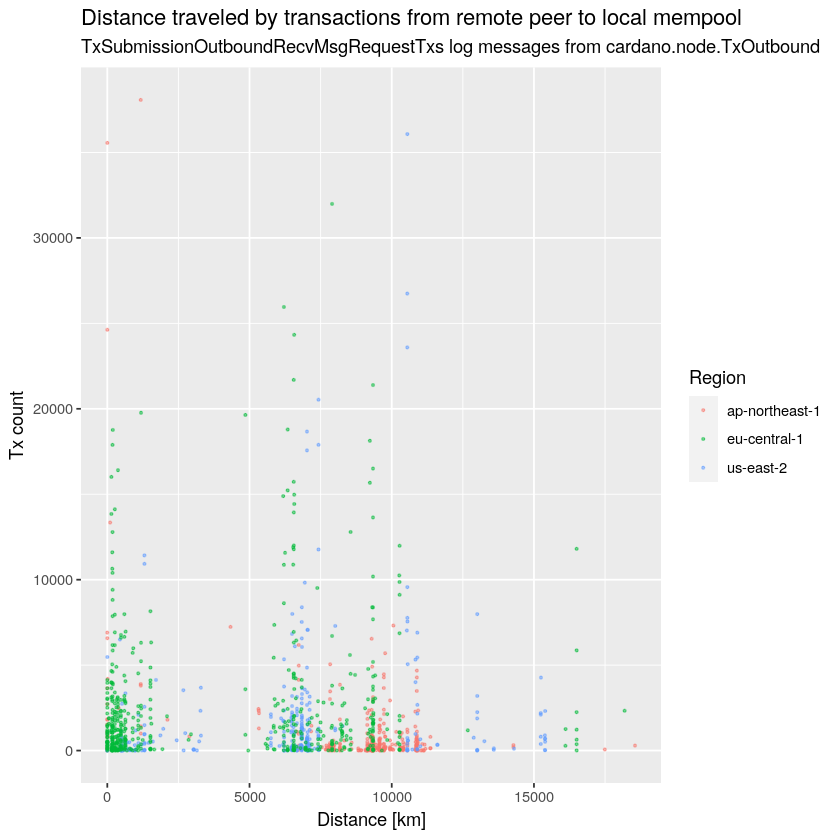

In [66]:
ggplot(
    connectivityDistance,
    aes(x=`Distance [km]`, y=`Tx count`, color=`Region`)
) +
    geom_point(size=0.5, alpha=0.5) +
    ggtitle(
        "Distance traveled by transactions from remote peer to local mempool",
        "TxSubmissionOutboundRecvMsgRequestTxs log messages from cardano.node.TxOutbound"
    )

In [67]:
ggsave("mempool-distance-scatter.png", units="in", dpi=150, width=8, height=6)

In [68]:
ggsave("mempool-distance-scatter.svg", units="in", dpi=150, width=8, height=6)

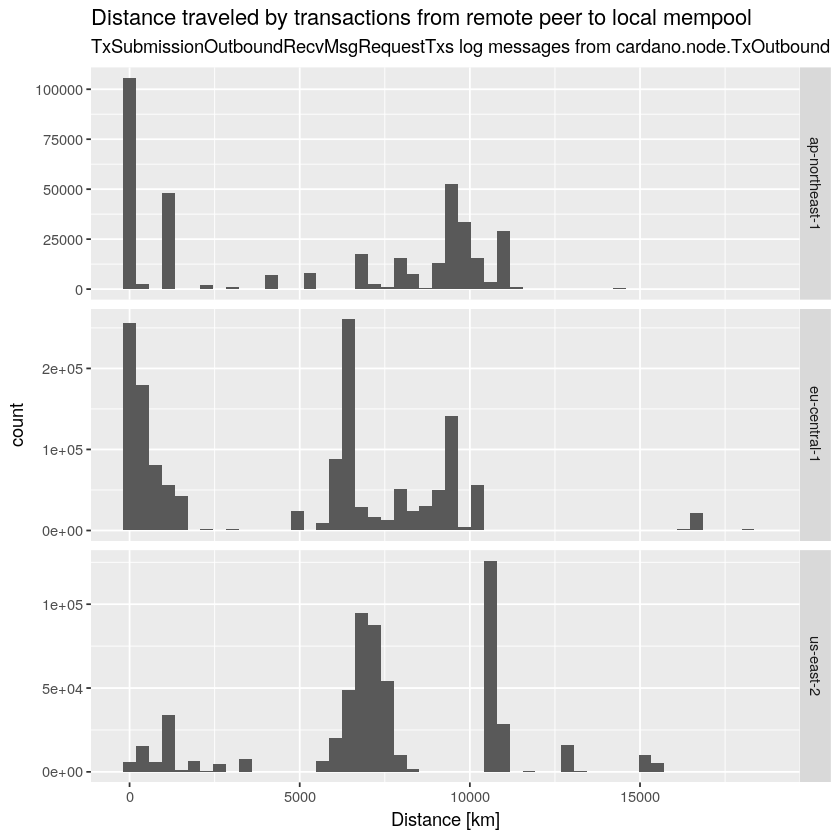

In [69]:
ggplot(
    connectivityDistance,
    aes(x=`Distance [km]`, weight=`Tx count`)
) +
    geom_histogram(bins=50) +
    facet_grid(`Region` ~ ., scales="free_y") +
    ggtitle(
        "Distance traveled by transactions from remote peer to local mempool",
        "TxSubmissionOutboundRecvMsgRequestTxs log messages from cardano.node.TxOutbound"
    )

In [70]:
ggsave("mempool-distance-histogram.png", units="in", dpi=150, width=8, height=6)

In [71]:
ggsave("mempool-distance-histogram.svg", units="in", dpi=150, width=8, height=6)

## Identification of node clusters of mempool correlation.

In [72]:
outboundsIndex <- rbind(
    connectivityDistance[, .(`Region`=head(`Region`, 1), `Tx count`=0), .(`Host`=`Local host`)],
    connectivityDistance[, .(`Region`="unknown", `Tx count`=sum(`Tx count`)), .(`Host`=`Remote host`)]
)[, .(`Region`=head(`Region`, 1), `Tx count`=max(`Tx count`)), .(`Host`)]
outboundsIndex[, `ID`:=.I]
outboundsIndex %>% summary

              Host                Region       Tx count             ID       
 100.36.30.173  :  1   ap-northeast-1:  1   Min.   :    0.0   Min.   :  1.0  
 103.147.114.194:  1   eu-central-1  :  1   1st Qu.:  271.8   1st Qu.:206.8  
 103.73.64.137  :  1   us-east-2     :  1   Median : 1163.0   Median :412.5  
 104.131.122.73 :  1   unknown       :821   Mean   : 2919.1   Mean   :412.5  
 104.167.218.211:  1                        3rd Qu.: 3005.2   3rd Qu.:618.2  
 104.225.220.71 :  1                        Max.   :57766.0   Max.   :824.0  
 (Other)        :818                                                         

In [73]:
outboundsGraph <- tbl_graph(
    nodes=outboundsIndex[, .(`id`=`ID`, `Region`, `Tx count`)],
    edges=connectivityDistance[
        outboundsIndex[, .(`from`=`ID`, `Local host`=`Host`)],
        on="Local host",
        nomatch=0
    ][
        outboundsIndex[, .(`to`=`ID`, `Remote host`=`Host`)],
        on="Remote host",
        nomatch=0
    ][, .(`Distance [km]`=mean(`Distance [km]`)), .(`from`, `to`)],
    directed=TRUE
)
outboundsGraph

# A tbl_graph: 824 nodes and 1169 edges
#
# A directed acyclic simple graph with 1 component
#
# Node Data: 824 × 3 (active)
     id Region         `Tx count`
  <int> <fct>               <dbl>
1     1 ap-northeast-1          0
2     2 us-east-2               0
3     3 eu-central-1         3046
4     4 unknown               625
5     5 unknown               405
6     6 unknown              1084
# … with 818 more rows
#
# Edge Data: 1,169 × 3
   from    to `Distance [km]`
  <int> <int>           <dbl>
1     2     3           6837.
2     1     4          10900.
3     1     5           7836.
# … with 1,166 more rows

Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


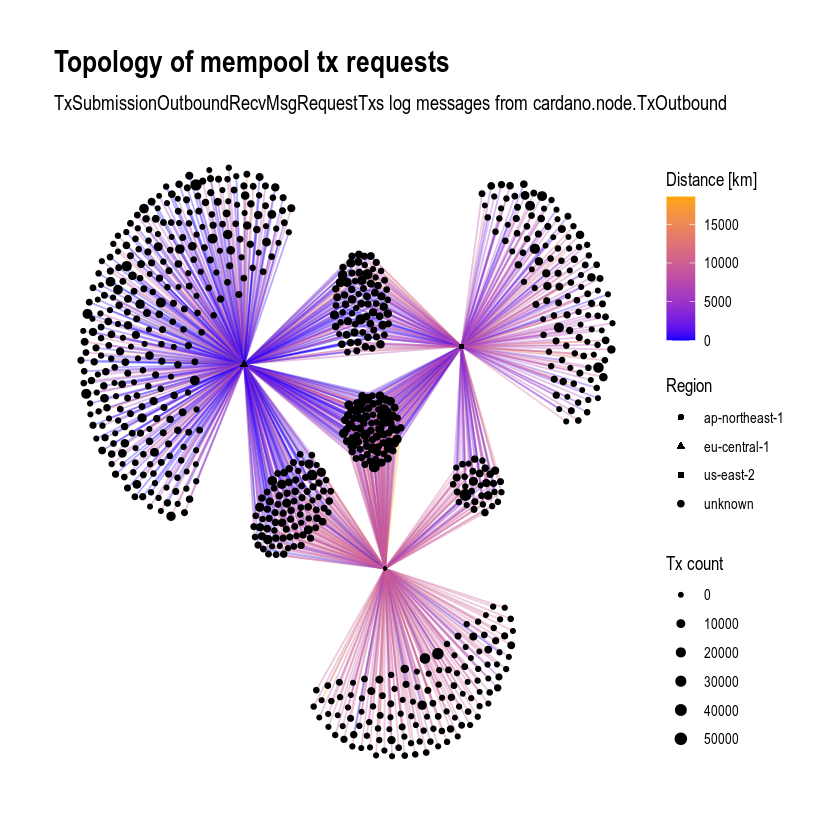

In [74]:
ggraph(outboundsGraph, layout="fr") +
    geom_edge_link(aes(color=`Distance [km]`), alpha=0.33) +
    geom_node_point(aes(shape=`Region`, size=`Tx count`)) +
    scale_edge_color_continuous(low="blue", high="orange") +
    scale_shape_manual(values=c(16, 17, 15, 19)) +
    scale_size_continuous(range=c(1, 3)) +
    theme_graph() +
    ggtitle(
        "Topology of mempool tx requests",
        "TxSubmissionOutboundRecvMsgRequestTxs log messages from cardano.node.TxOutbound"
    )

In [75]:
ggsave("mempool-distance-graph.png", units="in", dpi=150, width=8, height=6)

In [76]:
ggsave("mempool-distance-graph.svg", units="in", dpi=150, width=8, height=6)

In [77]:
connectivity[
    , 
    .(`Number of local hosts`=.N, `Tx count`=sum(`Tx count`)), 
    .(`Remote host`)
][
    ,
    .(`Number of remote hosts`=.N, `Tx count`=sum(`Tx count`)),
    .(`Number of local hosts`)
][
    ,
    .(`Number of local hosts`, `Fraction of txs`=`Tx count`/sum(`Tx count`), `Fraction of remote hosts`=`Number of remote hosts`/sum(`Number of remote hosts`)),
][order(`Number of local hosts`)]

Number of local hosts,Fraction of txs,Fraction of remote hosts
<int>,<dbl>,<dbl>
1,0.4868596,0.67153285
2,0.2903153,0.23479319
3,0.2228251,0.09367397
